In [8]:
from PIL import Image
# location = r'C:\Users\brugg\Documents\MasterThesis\02062022'
location = r'C:\Users\brugg\Documents\MasterThesis\02062022\100003.his'

# file = '100003'
# fullname = location + file + '.his'
# im = Image.open(fullname)
im = Image.open(location)


# filedir = 'D:\\20220405\\'
# fn = filedir + 'C'+str(no).zfill(5)+'.his'

UnidentifiedImageError: cannot identify image file 'C:\\Users\\brugg\\Documents\\MasterThesis\\02062022\\100003.his'

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

mmap_shape = None # default: map entire file; change this to handle BIG files

# 64 bytes
dtypeHIS = np.dtype([
    ('magic', 'a2'),
    ('ComLen', np.uint16),
    ('iDX', np.uint16),
    ('iDY', np.uint16),
    ('iX', np.uint16),
    ('iY', np.uint16),
    ('pixType', np.uint16),
    ('numImgs', np.uint32),
    ('numChan', np.uint16),
    ('chan', np.uint16),
    ('timeStamp', np.float64),
    ('marker', np.uint32),
    ('miscinfo', '30i1'),
    ])

hisType2numpyDtype = {
    1: np.uint8,
    2: np.uint16,
    3: np.uint32,
    11: ('RGB', (np.uint8, np.uint8, np.uint8)),
    12: ('RGB', (np.uint16, np.uint16, np.uint16)),
}

#20100224 class ndarray_inHisFile(N.ndarray):
#20100224     def __array_finalize__(self,obj):
#20100224         self.HIS = getattr(obj, 'HIS', None)

#http://docs.scipy.org/doc/numpy/user/basics.subclassing.html
# Simple example - adding an extra attribute to ndarray
class ndarray_inHisFile(np.ndarray):
    def __new__(cls, input_array, hisInfo=None):
        obj = np.asarray(input_array).view(cls)
        obj.HIS = hisInfo
        return obj

    def __array_finalize__(self, obj):
        if obj is None: return
        self.HIS = getattr(obj, 'HIS', None)

def _try_openHIS_fastMap(m):
    hisHdr0 = m[:64]
    hisHdr0.dtype = dtypeHIS
    try:
        hisHdr0 = hisHdr0[0]
    except IndexError:
        print("zero Bytes HIS file")

    imgPixDType = hisType2numpyDtype[ hisHdr0['pixType'] ]
    pixBytes = imgPixDType().itemsize
    nx,ny,nz = hisHdr0['iDX'],  hisHdr0['iDY'],  hisHdr0['numImgs']
    comLen=hisHdr0['ComLen']

    expectedBytes = (64 + pixBytes*nx*ny) * nz + comLen
    if expectedBytes != len(m):
        return None # there are probably comments in other sections, fastMap cannot be used

    mm = m[comLen:] # first hdr will be "corrupt", since comment is just before first imgData
    a = np.recarray(nz, dtype=[('hdr', dtypeHIS),
                               ( 'imgData', (imgPixDType, (ny,nx)) ),
                               ],
                    buf=mm)

    if comLen:
        hisComment = m[64:64+comLen]
        hisComment.dtype = '|S%d'%(comLen,)
    else:
        hisComment = ('',)
    comment = hisComment[0]  # there is "one" comment per sect

    class hisInfo:
        hdr0 = hisHdr0
        comment0 = comment
        hdr = a['hdr']

    fastHisArr = ndarray_inHisFile(a['imgData'], hisInfo=hisInfo)
    return fastHisArr

def readSection(m, offsetSect = 0):
    """
    m: numpy memmap of a file, create like m = np.memmap(fn, shape=None, mode = 'r') with fn the file name
    (it saves running time not to create a map each time)
    offsetSect: offset of first byte of section to be read, for next sections use offset = img.HIS.offsetNext
    """

    offsetComment = offsetSect + 64

    hisHdr = m[offsetSect:offsetComment]
    hisHdr.dtype = dtypeHIS
    try:
        hisHdr = hisHdr[0]
    except IndexError:
        print("End of HIS file reached")

    #assert hisHdr['magic'] == 'IM'

    commentLength = hisHdr['ComLen']
    offsetImg = offsetComment + commentLength

    if commentLength:
        hisComment = m[offsetComment:offsetImg]
        hisComment.dtype = '|S%d'%(hisHdr['ComLen'],)
    else:
        hisComment = ('',)
    imgPixDType = hisType2numpyDtype[hisHdr['pixType']]
    imgBytes = int(hisHdr['iDX']) * int(hisHdr['iDY']) * imgPixDType().itemsize
    
    sectEnd = offsetImg + imgBytes

    img = m[offsetImg:sectEnd]
    img.dtype = imgPixDType
    img.shape = hisHdr['iDY'], hisHdr['iDX']

    class hisHeaderInfo:
        hdr = hisHdr
        comment = hisComment[0]  # there is "one" comment per sect
        offsetNext = sectEnd

    img = ndarray_inHisFile(img, hisInfo=hisHeaderInfo)

    return img

def loadHISsec(fn, sec=0):
    #import os
    f = open(fn, "rb")
    offsetSect = 0
    iSec = 0
    global sectsOffsets, hisHdr, hisComment
    #sectsOffsets = []
    
    for i in range(sec+1):
        f.seek( offsetSect )
        hisHdr = np.fromfile(f, dtype=dtypeHIS, count=1)
        hisHdr = hisHdr[0]

        assert hisHdr['magic'] == 'IM'
        offsetComment = offsetSect + 64
        commentLength = hisHdr['ComLen']
        offsetImg     = offsetComment + commentLength
        imgPixDType = hisType2numpyDtype[ hisHdr['pixType'] ]
        imgBytes = int(hisHdr['iDX']) * int(hisHdr['iDY']) * imgPixDType().itemsize
        
        sectEnd = offsetImg + imgBytes
        offsetSect = sectEnd
        #sectsOffsets.append( offsetSect )
        #f.seek(offsetSect+64+commentLength+imgBytes)  os.SEEK_CUR)

    
    hisComment = f.read(commentLength)
    imgShape = hisHdr['iDY'], hisHdr['iDX']
    img = np.fromfile(f, dtype=imgPixDType, count=np.prod(imgShape))
    img.shape = imgShape = hisHdr['iDY'], hisHdr['iDX']

    return img


In [29]:
filedir = 'C:\\Users\\brugg\\Documents\\MasterThesis\\02062022\\'
fn = filedir + '100003.his'

nframes = 199
print(fn)

C:\Users\brugg\Documents\MasterThesis\02062022\100003.his


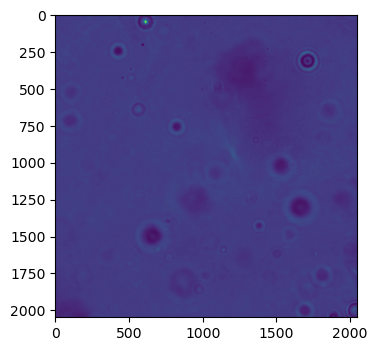

In [48]:
m = np.memmap(fn, shape=None, mode = 'r')
offset = 0
img = readSection(m, offset)
plt.figure()

imgplot = plt.imshow(img)

In [51]:
# movie = np.memmap((nframes,img.shape[0],img.shape[1]), dtype=np.uint16)
# movie = np.memmap((nframes)

movie = np.memmap(fn, shape=None, mode ='r')
offset = 0

def function(nframes, movie, offset):
    for i in range(nframes):
#         img = readSection(m,offset)
        img = readSection(offset)
        offset = img.HIS.offsetNext
        movie[i] = np.copy(img)
    return movie


In [52]:
function

<function __main__.function(nframes, movie, offset)>

In [53]:
print(movie)

[73 77 66 ... 41 94 40]


In [54]:
def execute_movie(movie):
    plt.rcParams["animation.html"] = "jshtml"
    plt.rcParams['figure.dpi'] = 100  
    plt.ioff() 
    
    fig = plt.figure()
    axis = plt.axes()
    
    film = plt.imshow(movie[0])
    
    def init(): 
        film.set_data(movie[0])
        return [film]
    
    
    def animate(i):
        film.set_array(movie[i])
        return [film]
    fig.suptitle('Measurement '+str(no))
    
    anim = FuncAnimation(fig, animate, init_func = init, 
                         frames = nframes, interval = 20, blit = True)

    return anim


#%%



#Or play the movie with the borders cut:
#Call the function in the console
def execute_movie_cut():

    fig = plt.figure()  
    axis = plt.axes()

    film = plt.imshow(movie[0][border_ver1:border_ver2,border_hor1:border_hor2])

    def init(): 
        film.set_data(movie[0][border_ver1:border_ver2,border_hor1:border_hor2])
        return [film]

    def animate(i):
        film.set_array(movie[i][border_ver1:border_ver2,border_hor1:border_hor2])
        return [film]
    
    fig.suptitle('Measurement cut '+str(no))
   
    
    anim = FuncAnimation(fig, animate, init_func = init,
                         frames = nframes, interval = 20, blit = True)

    
    return anim

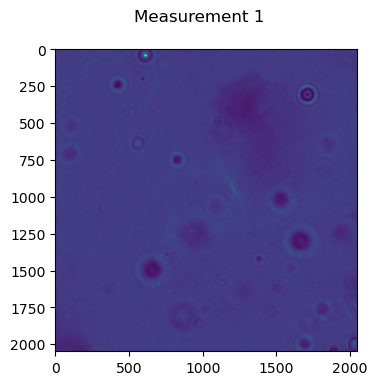

In [28]:
execute_movie(movie)

In [55]:
file = open(fn, 'r')
inp = file.readlines()

UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 14: character maps to <undefined>

In [57]:
import sys
sys.getsizeof(inp) #returns the size of the object

NameError: name 'inp' is not defined